In [1]:
import pysensors as ps
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle

### Load the Olivetti Dataset

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [4]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [5]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

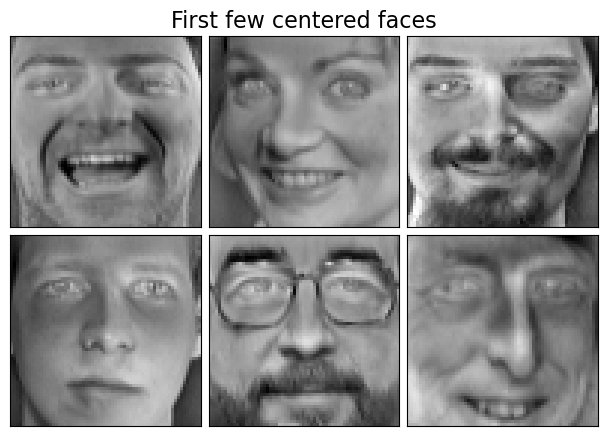

In [6]:
plot_gallery("First few centered faces", X[:n_components])

In [7]:
X_train, X_test = X[:300], X[300:]

### Unconstrained sensor placaement:


In [8]:
n_sensors = 10
n_modes = 10
basis_unconst = ps.basis.SVD(n_basis_modes = n_modes)
optimizer_unconst = ps.optimizers.QR()
model_unconst = ps.SSPOR(basis = basis_unconst, optimizer = optimizer_unconst, n_sensors = n_sensors)
model_unconst.fit(X_train)
all_sensors_unconst = model_unconst.get_all_sensors()
sensors_unconst = model_unconst.get_selected_sensors()

/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [9]:
xTopUnc = np.mod(sensors_unconst,np.sqrt(n_features))
yTopUnc = np.floor(sensors_unconst/np.sqrt(n_features))
xAllUnc = np.mod(all_sensors_unconst,np.sqrt(n_features))
yAllUnc = np.floor(all_sensors_unconst/np.sqrt(n_features))

In [10]:
#Sensor ID corresponds to the column number chosen
columns = ['Sensor ID','SensorX','sensorY'] 
unconstrainedSensors_df = pd.DataFrame(data = np.vstack([sensors_unconst,xTopUnc,yTopUnc]).T,columns=columns,dtype=int)
unconstrainedSensors_df.head(n_sensors)

,Sensor ID,SensorX,sensorY
0,4032,0,63
1,594,18,9
2,384,0,6
3,878,46,13
4,446,62,6
5,2772,20,43
6,4041,9,63
7,3936,32,61
8,340,20,5
9,2273,33,35


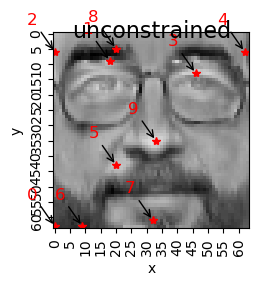

In [11]:
# Plot the constrained region and the unconstrained sensors where 1 is the first sensor chosen.
image = X_train[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

### Functional constaints:

Suppose the user wants to constrain a circular aea centered at x = 20, y = 30 with a radius (r = 5)

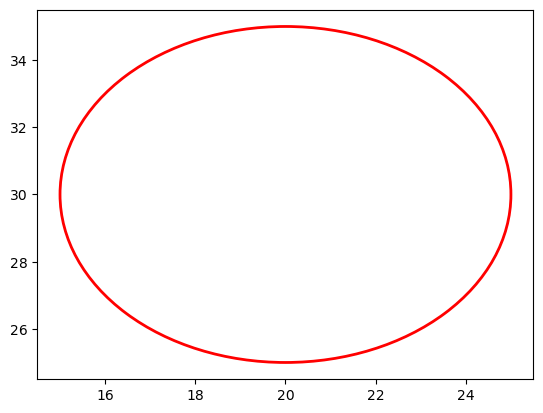

In [12]:
circle = ps.utils._constraints.Circle(center_x = 20, center_y = 30, radius = 5, loc = 'out', data = X_train) #Plotting the constrained circle 
circle.draw_constraint() ###Plotting just the constraint

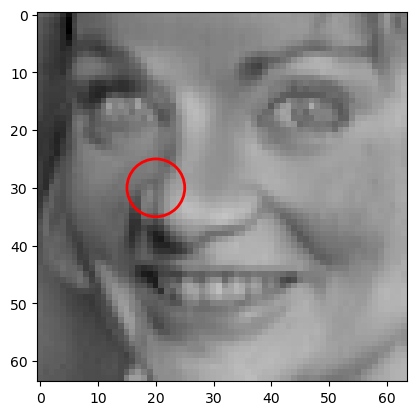

In [13]:
circle.plot_constraint_on_data(plot_type='image') ##Plotting the constraint on the data

### Plotting grid of possible sensor locations

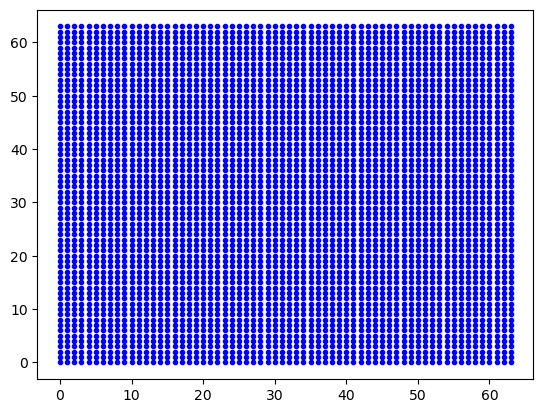

In [14]:
circle.plot_grid(all_sensors=all_sensors_unconst)

### Obtaining constrained indices :

In [15]:
const_idx, rank = circle.get_constraint_indices(all_sensors = all_sensors_unconst,info=(64,64))  #get_indices

In [16]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 1

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_circle = ps.optimizers.GQR()
opt_exact_kws={'idx_constrained':const_idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_exact = ps.basis.SVD(n_basis_modes=n_sensors)

In [17]:
# Initialize and fit the model
model_exact = ps.SSPOR(basis = basis_exact, optimizer = optimizer_circle, n_sensors = n_sensors)
model_exact.fit(X_train,**opt_exact_kws)

# sensor locations based on columns of the data matrix
top_sensors_exact = model_exact.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConst = np.mod(top_sensors_exact,np.sqrt(n_features))
yTopConst = np.floor(top_sensors_exact/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032 2068 1945 2136 1751 2199 1620 1943 1941 2128]


/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [18]:
data_sens_circle = circle.sensors_dataframe(sensors = top_sensors_exact)
data_sens_circle

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,2068.0,20.0,32.0
2,1945.0,25.0,30.0
3,2136.0,24.0,33.0
4,1751.0,23.0,27.0
5,2199.0,23.0,34.0
6,1620.0,20.0,25.0
7,1943.0,23.0,30.0
8,1941.0,21.0,30.0
9,2128.0,16.0,33.0


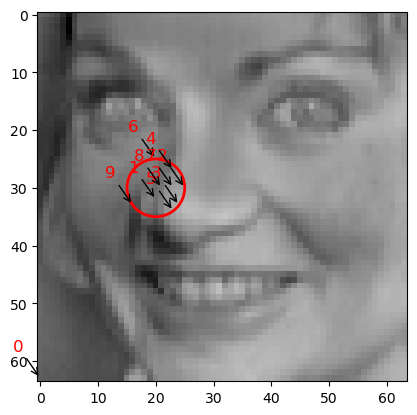

In [19]:
circle.plot_constraint_on_data(plot_type='image')
circle.annotate_sensors(sensors = top_sensors_exact)

### We want to constrain the region beyond x = 10 and x = 20 and y = 0 and y = 64

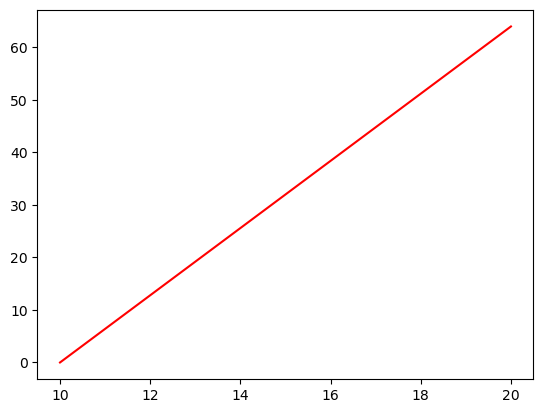

In [20]:
line1 = ps.utils._constraints.Line(x1 = 10, x2 = 20, y1 = 0, y2 = 64, data = X_train) #Plotting the constrained line  ##expect a tuple of (x,y)
line1.draw_constraint() ## plotting just the constraint

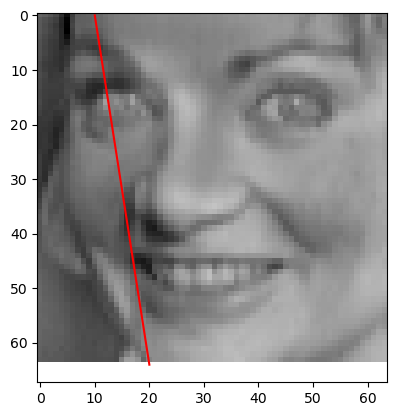

In [21]:
line1.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data

In [22]:
const_idx1, rank1 = line1.get_constraint_indices(all_sensors=all_sensors_unconst, info = (64,64))

In [23]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 5

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_line = ps.optimizers.GQR()
opt_line_kws={'idx_constrained':const_idx1,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_line = ps.basis.SVD(n_basis_modes=n_sensors)

In [24]:
# Initialize and fit the model
model_line = ps.SSPOR(basis = basis_line, optimizer = optimizer_line, n_sensors = n_sensors)
model_line.fit(X_train,**opt_line_kws)

# sensor locations based on columns of the data matrix
top_sensors_line = model_line.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstLine = np.mod(top_sensors_line,np.sqrt(n_features))
yTopConstLine = np.floor(top_sensors_line/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032 2068 1945 2136 1751 2199 1620 1943 1941 2128]


/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [25]:
data_sens_line = line1.sensors_dataframe(sensors = top_sensors_line)
data_sens_line

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,393.0,9.0,6.0
9,3922.0,18.0,61.0


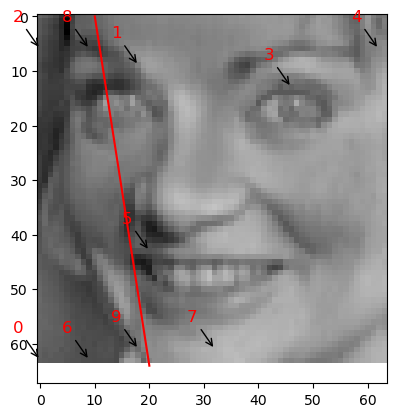

In [26]:
line1.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
line1.annotate_sensors(sensors = top_sensors_line)

### Testing Ellipse: 

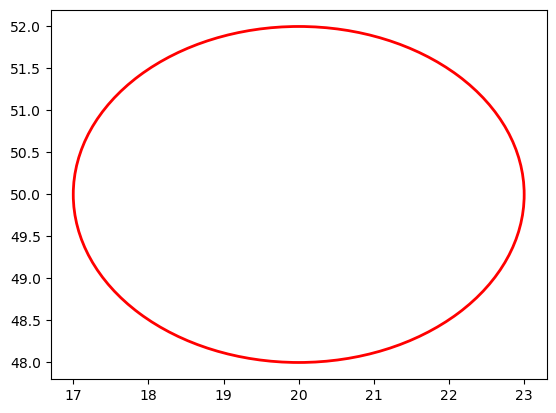

In [27]:
ellipse = ps.utils._constraints.Ellipse(center_x = 20, center_y = 50, half_major_axis = 6, half_minor_axis = 4, loc = 'out',data = X_train) #Plotting the constrained circle 
ellipse.draw_constraint() ###Plotting just the constraint

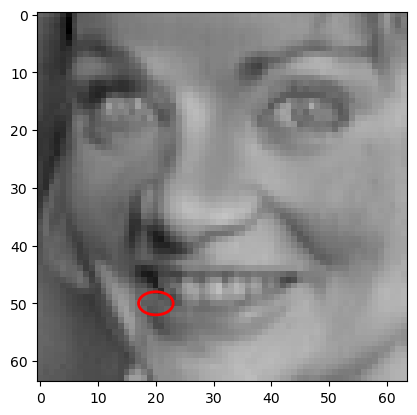

In [28]:
ellipse.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data

In [29]:
const_idx_ellipse, rank_ellipse = ellipse.get_constraint_indices(all_sensors=all_sensors_unconst, info = (64,64))

In [39]:
# Define the number of constrained sensors allowed (s)
n_const_sen_ellipse = 1

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_ellipse = ps.optimizers.GQR()
opt_ellipse_kws={'idx_constrained':const_idx_ellipse,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_ellipse,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_ellipse = ps.basis.SVD(n_basis_modes=n_sensors)

In [40]:
# Initialize and fit the model
model_ellipse = ps.SSPOR(basis = basis_ellipse, optimizer = optimizer_ellipse, n_sensors = n_sensors)
model_ellipse.fit(X_train,**opt_ellipse_kws)

# sensor locations based on columns of the data matrix
top_sensors_ellipse = model_ellipse.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstEllipse = np.mod(top_sensors_ellipse,np.sqrt(n_features))
yTopConstEllipse = np.floor(top_sensors_ellipse/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_ellipse))

The list of sensors selected is: [4032 3221 3031 3214 3093 3226 3217 3353 3347 3157]


/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [41]:
data_sens_ellipse = ellipse.sensors_dataframe(sensors = top_sensors_ellipse)
data_sens_ellipse

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,3221.0,21.0,50.0
2,3031.0,23.0,47.0
3,3214.0,14.0,50.0
4,3093.0,21.0,48.0
5,3226.0,26.0,50.0
6,3217.0,17.0,50.0
7,3353.0,25.0,52.0
8,3347.0,19.0,52.0
9,3157.0,21.0,49.0


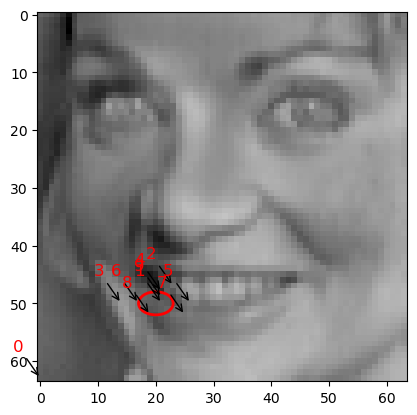

In [42]:
ellipse.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
ellipse.annotate_sensors(sensors = top_sensors_ellipse)

## User defined constraints

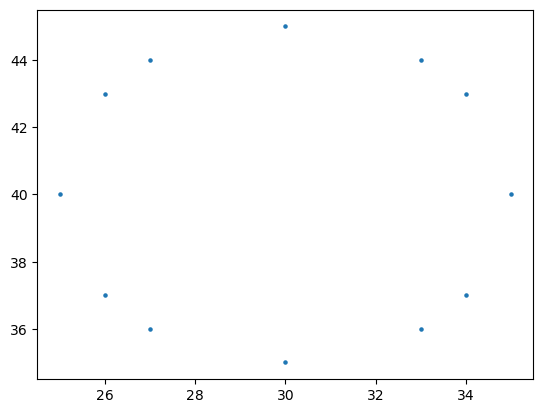

In [34]:
user_const = 'userExplicitConstraint1.py'
user_const_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors_unconst,(64,64),user_const, data = X_train)
idx, rank = user_const_instance.constraint()
user_const_instance.draw_constraint() ## plot the user defined constraint just by itself

In [35]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 4

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user = ps.optimizers.GQR()
opt_user_kws={'idx_constrained':idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_user = ps.basis.SVD(n_basis_modes=n_sensors)

In [36]:
# Initialize and fit the model
model_user = ps.SSPOR(basis = basis_user, optimizer = optimizer_user, n_sensors = n_sensors)
model_user.fit(X_train,**opt_user_kws)

# sensor locations based on columns of the data matrix
top_sensors_user = model_user.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstUser = np.mod(top_sensors_user,np.sqrt(n_features))
yTopConstUser = np.floor(top_sensors_user/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032 2068 1945 2136 1751 2199 1620 1943 1941 2128]


/Users/karnn/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [37]:
data_sens_user = user_const_instance.sensors_dataframe(sensors = top_sensors_user)
data_sens_user

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,2587.0,27.0,40.0
7,2466.0,34.0,38.0
8,2395.0,27.0,37.0
9,2658.0,34.0,41.0


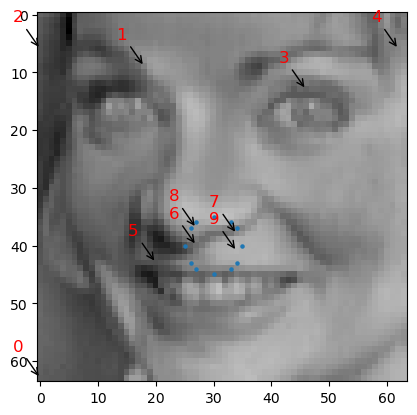

In [38]:
## Verifying whther user-defined constraints work

user_const_instance.plot_constraint_on_data(plot_type='image') 
user_const_instance.annotate_sensors(sensors = top_sensors_user)